In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import pennylane as qml
from scipy.linalg import expm
from itertools import product

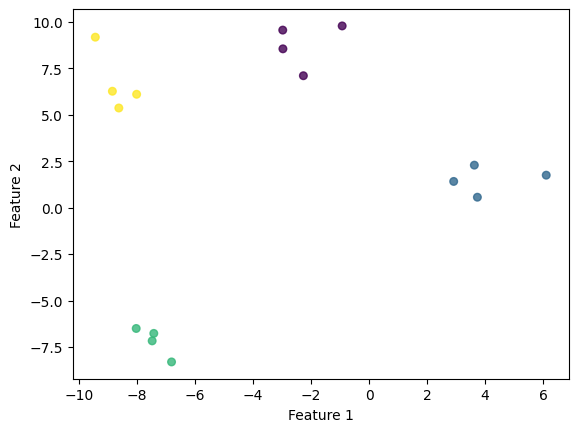

In [28]:
# data generation
X, Y = datasets.make_blobs(n_samples=16, centers=4, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# matrices
A = np.exp(-pairwise_distances(X, metric='euclidean'))
D = np.diag(np.sum(A, axis=1))
L = D - A
L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
L_inv_norm = L_inv / np.linalg.norm(L_inv)

In [29]:
# check if a matrix is Hermitian
def check_hermitain(A):
    return np.allclose(A, A.conj().T)

def check_unitary(A):
    I = np.eye(A.shape[0])
    return np.allclose(A.conj().T @ A, I) and np.allclose(A @ A.conj().T, I)

print("hermitian : ", check_hermitain(L), check_hermitain(L_inv), check_hermitain(L_inv_norm))
print("unitary : ", check_unitary(L), check_unitary(L_inv), check_unitary(L_inv_norm))
print("unitary : ", check_unitary(expm(-1j*L)), check_unitary(expm(-1j*L_inv)), check_unitary(expm(-1j*L_inv_norm)))

hermitian :  True True True
unitary :  False False False
unitary :  True True True


In [52]:
def check_divisibility(a, b):
    if a % b == 0:
        return 1
    else:
        return 0

def lcu(A):
    LCU = qml.pauli_decompose(A)
    coeff_A, op_A = LCU.terms()
    print("# of original terms :", len(coeff_A))
    N = int(np.power(2,np.floor(math.log2(len(coeff_A)))))
    if check_divisibility(len(coeff_A), N) == 0:
        coeff_A, op_A = lcu_reduction(coeff_A, op_A, N) # variables replaced
    coeff_A_sqrt = np.sqrt([abs(i) for i in coeff_A])
    norm_coeff_A = coeff_A_sqrt / np.linalg.norm(coeff_A_sqrt)
    return norm_coeff_A, op_A

def lcu_reduction(coeff_A, op_A, N): # extract N top_A terms
    coeff_A = coeff_A[1:] # exclude the first terms
    op_A = op_A[1:]
    idx = np.argsort(coeff_A)[-N:][::-1]
    coeff_A_red = [coeff_A[i] for i in idx]
    op_A_red = [op_A[i] for i in idx]
    return coeff_A_red, op_A_red
    
def init_config(A, coeff_A):
    n_control_A = int(np.floor(math.log2(len(coeff_A))))
    n_target_A = int(math.log2(A.shape[0]))
    return n_control_A, n_target_A

def get_basis_state(n_qubits):
    return [list(state) for state in product([0, 1], repeat=n_qubits)]

def init_state(iter_num, input_coeff_A, n_target_A):
    if iter_num==0:
        for i in reg_A['target']:
            qml.Hadamard(i)
    else:
        base = get_basis_state(n_target_A)
        qml.Superposition(input_coeff_A, base, reg_A['target'], work_wire=reg_A['super_work'])

def block_encoding(coeff_A, op_A):
    qml.StatePrep(coeff_A, wires=reg_A['control'])
    qml.Select(op_A, control=reg_A['control'])
    qml.adjoint(qml.StatePrep(coeff_A, wires=reg_A['control']))

def block_encoding_list(coeff_A, op_A):
    return [qml.StatePrep(coeff_A, wires=reg_A['control']), qml.Select(op_A, control=reg_A['control']), qml.adjoint(qml.StatePrep(coeff_A, wires=reg_A['control']))]
    
def zero_projector(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))]

def get_next_vec(vec, reg_A):
    proj_idx = zero_projector(n_tot_A, measured_wires=reg_A.tolist(), outcomes=np.zeros(len(reg_A), dtype=int).tolist())
    proj = np.array([vec[i] for i in proj_idx]) # project onto |0> in the control qubit
    proj = proj[0::2] # effectively remove the auxiliary qubit
    proj_norm_coeff_A = np.linalg.norm(proj)
    proj_norm = proj / proj_norm_coeff_A
    # iter_num +=1
    return proj_norm_coeff_A, np.real(proj), np.real(proj_norm)

def update_circuit_config(def_A):
    global A, coeff_A, op_A, n_control_A, n_target_A, n_tot_A, scaling_factor_A, dev_A, reg_A
    A = def_A
    coeff_A, op_A = lcu(A)
    print(len(coeff_A))
    n_control_A, n_target_A = init_config(A, coeff_A)
    n_tot_A = n_control_A+n_target_A+1
    scaling_factor_A = sum(abs(coeff_A))
    dev_A = qml.device("default.qubit", n_tot_A) 
    reg_A = qml.registers({"control": n_control_A, "target": n_target_A, "super_work":1}) 
    op_A = [qml.map_wires(op_A_elem, {i: i + n_control_A for i in range(n_target_A)}) for op_A_elem in op_A]

In [31]:
A = coeff_A = op_A = n_control_A = n_target_A = n_tot_A = scaling_factor_A = dev_A = reg_A = 0
update_circuit_config(L_inv_norm)
@qml.qnode(dev_A)
def power_circuit(A, iter_num, coeff_A, op_A, input_coeff_A, n_target_A):
    init_state(iter_num, input_coeff_A, n_target_A)
    block_encoding(coeff_A, op_A)
    return qml.expval(qml.Hermitian(A, wires=reg_A['target'])), qml.state()

# of original terms : 136
128


In [45]:
def power_method(A, num_iter=20, tol=1e-4):
    iter_num = 0
    input_coeff_A = 0
    proj_norm_coeff_As = []
    vals = []
    vecs = []

    while iter_num < num_iter:
        val, vec = power_circuit(A, iter_num, coeff_A, op_A, input_coeff_A, n_target_A)
        proj_norm_coeff_A, proj, proj_norm = get_next_vec(vec, reg_A['control'])

        if iter_num != 1:
            proj_norm_coeff_As.append(proj_norm_coeff_A)

        vec = np.prod(proj_norm_coeff_As) * proj
        vecs.append(vec)
        val = (vec.T @ (A @ vec)) / (vec.T @ vec)
        vals.append(val)

        # stop_Aping criteria
        if iter_num > 0 and abs(vals[-1] - vals[-2]) < tol:
            print(f"program stops at {iter_num}th iteration")
            break
 
        # updates for the next iteration
        iter_num += 1
        input_coeff_A = proj_norm

    return vals[-1], vecs[-1]

In [57]:
def get_eigspace(val,vec):
    return val*np.outer(vec,vec)

def update_circuit_config_AB(def_A, def_B):
    global A, coeff_A, op_A, n_control_A, n_target_A, n_tot_A, scaling_factor_A, dev_A, reg_A
    global B, coeff_B, op_B, n_control_AB, n_target_AB, n_tot_AB, scaling_factor_B, dev_AB, reg_AB

    B = def_B
    coeff_B, op_B = lcu(B)

    # compare the number of terms and choose a smaller one
    # n_control_A, n_target_A = init_config(A, coeff)
    n_control_B, n_target_B = init_config(B, coeff_B)
    n_control_AB = min(n_control_A, n_control_B)
    n_target_AB = min(n_target_A, n_target_B)
    n_tot_AB = n_control_AB+n_target_AB+1
    
    # scaling_factor_A = sum(abs(coeff_A))
    scaling_factor_B = sum(abs(coeff_B))
    
    dev_AB = qml.device("default.qubit", n_tot_AB) 
    reg_AB = qml.registers({"control": n_control_AB, "target": n_target_AB, "sub_aux":1})
    op_A = [qml.map_wires(op_elem, {i: i + n_control_AB for i in range(n_target_AB)}) for op_elem in op_A]
    op_B = [qml.map_wires(op_elem, {i: i + n_control_AB for i in range(n_target_AB)}) for op_elem in op_B]

coeff_B = op_B = n_control_AB = n_target_AB = n_tot_AB = scaling_factor_B = dev_AB = reg_AB = 0
B = A # to define circuit; updated later
update_circuit_config_AB(A, B)
@qml.qnode(dev_AB)
def deflation_circuit(A, B, coeff_A, op_A, coeff_B, op_B):
    # init_state(iter_num, input_coeff, n_target)
    qml.Hadamard(reg_AB['sub_aux'])
    for be_elem in block_encoding_list(coeff_A, op_A):
        qml.ctrl(be_elem, control=reg_AB['sub_aux'], control_values='0')
    for be_elem in block_encoding_list(coeff_B, op_B):
        qml.ctrl(be_elem, control=reg_AB['sub_aux'], control_values='1')
    qml.Hadamard(reg_AB['sub_aux'])
    return qml.state()

# of original terms : 136


In [84]:
def_vec = []
def_mat = A

num_eig_pair = 1 # bear in mind that the first pair lacks the ability to group data

for i in range(num_eig_pair):
    global A, B, coeff_A, op_A, coeff_B, op_B
    eig_val, eig_vec = power_method(def_mat)
    def_vec.append(eig_vec)
    B = get_eigspace(eig_val, eig_vec)
    update_circuit_config_AB(A, B)
    # def_mat = deflation()
    # def_mat = deflate(def_mat, eig_val, eig_vec)
    # update_circuit_config_A(def_mat)

program stops at 1th iteration
# of original terms : 135


In [90]:
pd.DataFrame(A-B).shape

(16, 16)

In [86]:
state = deflation_circuit(A, B, coeff_A, op_A, coeff_B, op_B)

In [87]:
# post-processing on the state from deflation_circuit
def one_projector_aux(state, n_tot_AB):
    selected_idx = [i for i in range(len(state)) if format(i, f'0{n_tot_AB}b')[-1] == '1']
    state = state[selected_idx]
    return state / np.linalg.norm(state)

state_aux_removed = one_projector_aux(state, n_tot_AB)
state_aux_removed.shape

(2048,)

In [88]:
vec_AB = one_projector_aux(state, n_tot_AB)
proj_idx_AB = zero_projector(n_tot_AB, measured_wires=reg_AB['control'].tolist(), outcomes=np.zeros(len(reg_AB['control']), dtype=int).tolist())
proj_AB = np.array([vec_AB[i] for i in proj_idx_AB]) # project onto |0> in the control qubit
proj_norm_coeff_AB = np.linalg.norm(proj_AB)
proj_norm_AB = proj_AB / proj_norm_coeff_AB
proj_norm_AB.shape

(32,)

In [ ]:
for i in def_vec:
    print(i[0])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(np.zeros(len(def_vec[1])), def_vec[1], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[0].set_title('2nd eigenvector')

axs[1].scatter(np.zeros(len(def_vec[2])), def_vec[2], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[1].set_title('3rd eigenvector')

axs[2].scatter(np.zeros(len(def_vec[3])), def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[2].set_title('4th eigenvector')

fig.suptitle('Data embedded on LE')
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(def_vec[1], def_vec[2], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[1].scatter(def_vec[1], def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[2].scatter(def_vec[2], def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)

fig.suptitle('Data embedded on LE')
plt.tight_layout()
plt.show()